In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.axis as maxis

# import dataframe_image as dfi
# import df2img

import scipy.optimize as opt

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

import json
import os
import sys
import tqdm
import time
import datetime

In [2]:
df_prices = pd.read_csv('../code/data/crypto.csv', index_col='dt', parse_dates=['dt'])
df_prices.drop('TON-USDT', axis=1, inplace=True)
df_prices.columns = [c.split('-')[0] for c in df_prices.columns]
df_prices.head()

,BTC,ETH,DOT,OKB,XRP,SOL,TRX,LTC
dt,,,,,,,,
2020-01-01 19:00:00,7131.9,129.56,NaN,NaN,0.19050,NaN,0.01312,41.17
2020-01-02 19:00:00,7319.7,132.47,NaN,NaN,0.19203,NaN,0.01337,41.76
2020-01-03 19:00:00,7318.9,133.29,NaN,NaN,0.19249,NaN,0.01335,42.28
2020-01-04 19:00:00,7467.4,137.24,NaN,NaN,0.19628,NaN,0.01377,44.01
2020-01-05 19:00:00,7520.9,140.18,NaN,NaN,0.21275,NaN,0.01405,44.06


In [3]:
days_shift = 7
df_returns = df_prices.diff(days_shift) / df_prices.shift(days_shift)
df_returns = df_returns[df_returns.isna().sum(axis=1) == 0]

df_returns = df_returns[df_returns.index >= '2022-01-01']

n_observations, n_assets = df_returns.shape
print(n_observations, n_assets)
df_returns.head()

1095 8


,BTC,ETH,DOT,OKB,XRP,SOL,TRX,LTC
dt,,,,,,,,
2022-01-01 19:00:00,-0.054014,-0.067913,-0.005263,-0.048031,-0.067994,-0.110254,-0.035776,-0.023856
2022-01-02 19:00:00,-0.092438,-0.075290,-0.067066,-0.070249,-0.103108,-0.151931,-0.058294,-0.065561
2022-01-03 19:00:00,-0.041478,-0.012844,0.008603,-0.035905,-0.054473,-0.072116,-0.022158,-0.004834
2022-01-04 19:00:00,-0.028151,0.006730,0.044412,-0.048068,-0.019920,-0.045850,-0.012687,-0.005669
2022-01-05 19:00:00,-0.088865,-0.083878,-0.050395,-0.093272,-0.089935,-0.138798,-0.092972,-0.086360


In [5]:
df_returns.describe()

,BTC,ETH,DOT,OKB,XRP,SOL,TRX,LTC
count,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000
mean,0.007286,0.003782,-0.003124,0.007685,0.013155,0.011367,0.010538,0.002451
std,0.077889,0.096069,0.111003,0.093618,0.132847,0.148224,0.080004,0.100077
min,-0.332838,-0.383014,-0.392469,-0.359057,-0.359555,-0.601772,-0.316207,-0.339202
25%,-0.035792,-0.047654,-0.072418,-0.040125,-0.050642,-0.076466,-0.023570,-0.051345
50%,0.002585,-0.001282,-0.008418,-0.001591,-0.000290,-0.003390,0.010607,0.000141
75%,0.044573,0.055515,0.057267,0.049402,0.042995,0.090647,0.037312,0.054629
max,0.356565,0.505611,0.618821,0.400260,1.023532,0.740882,0.740697,0.529393


## Описательная статистика

In [6]:
plt.rcParams.update({'font.size': 12})

In [9]:
df_prices.index.min()

Timestamp('2020-01-01 19:00:00')

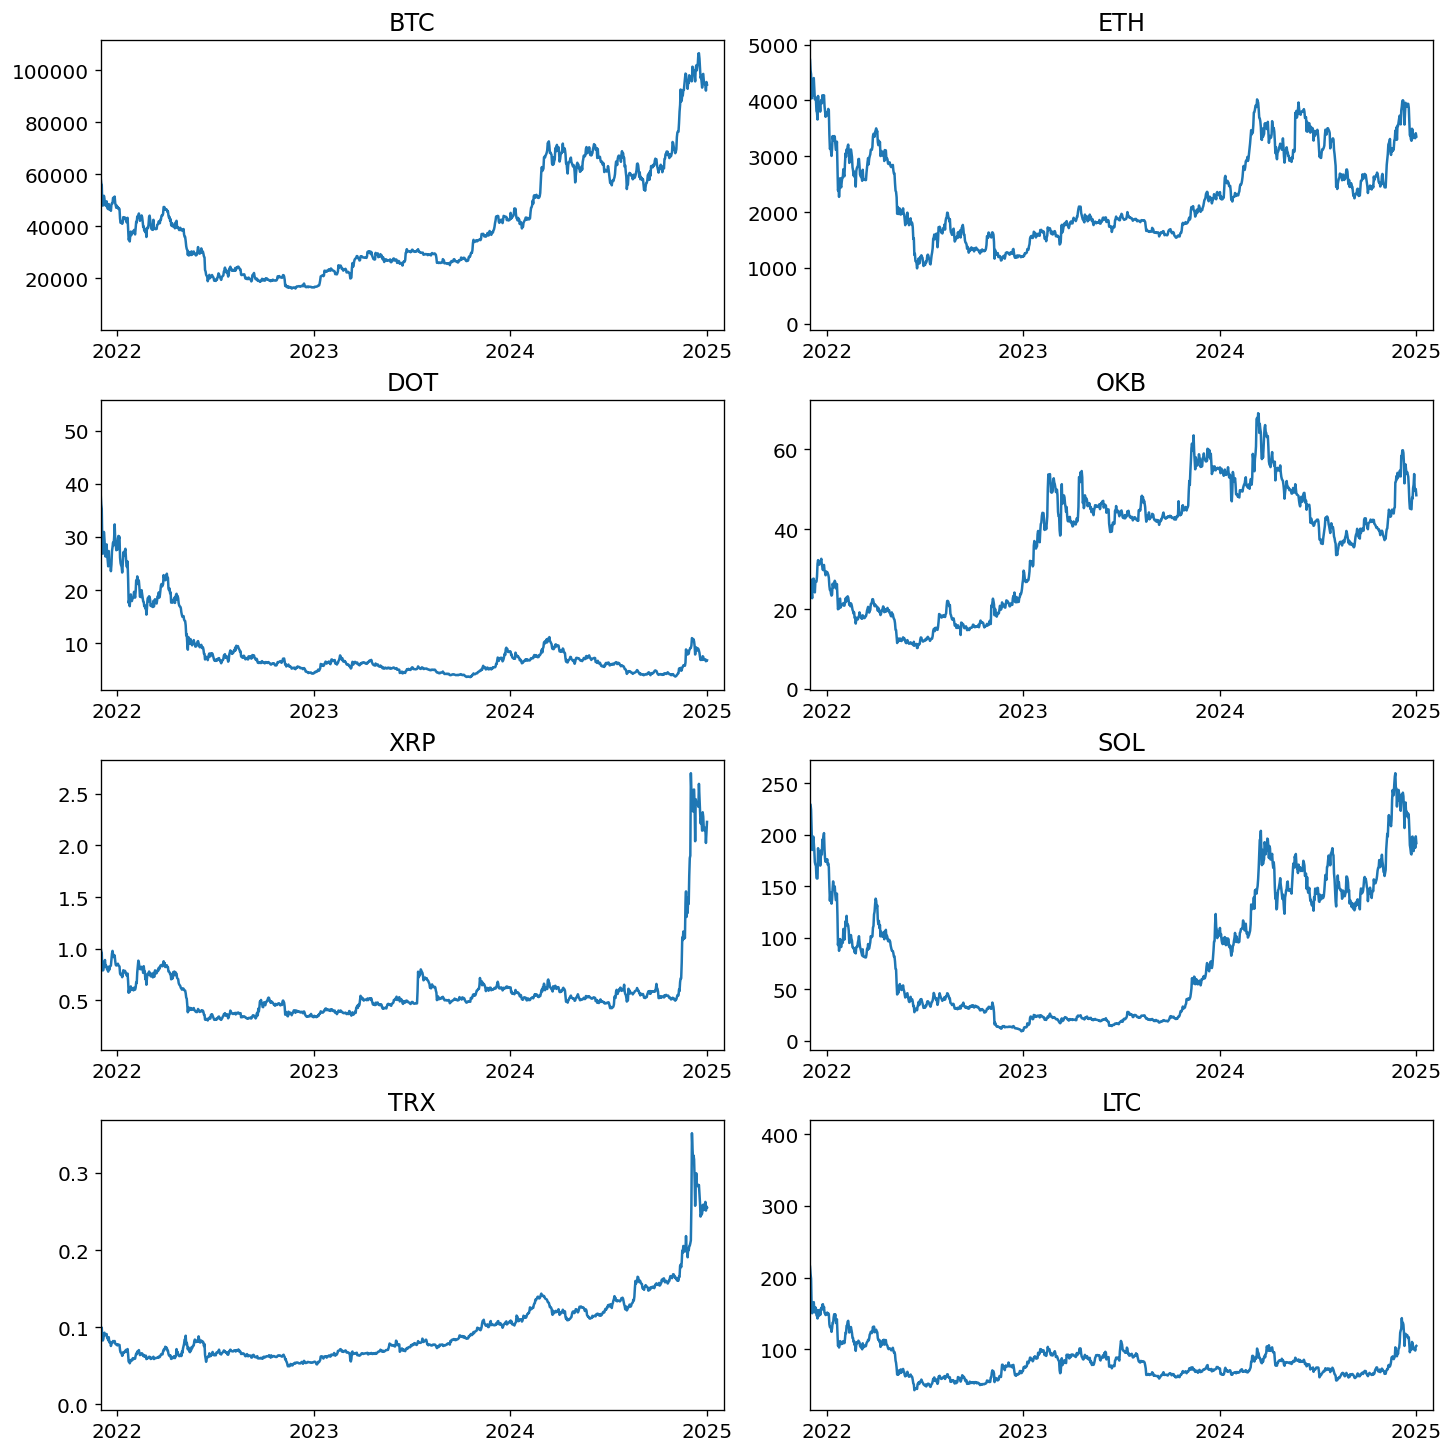

In [18]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 12), dpi=120, layout='constrained')
for c, ax in zip(df_prices.columns, axs.flatten()):
    ax.plot(df_prices[c])
    ax.set_title(c)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.set_xlim(datetime.date(2021, 12, 1), datetime.datetime(2025, 2, 1))
fig.savefig('../images/prices.png')

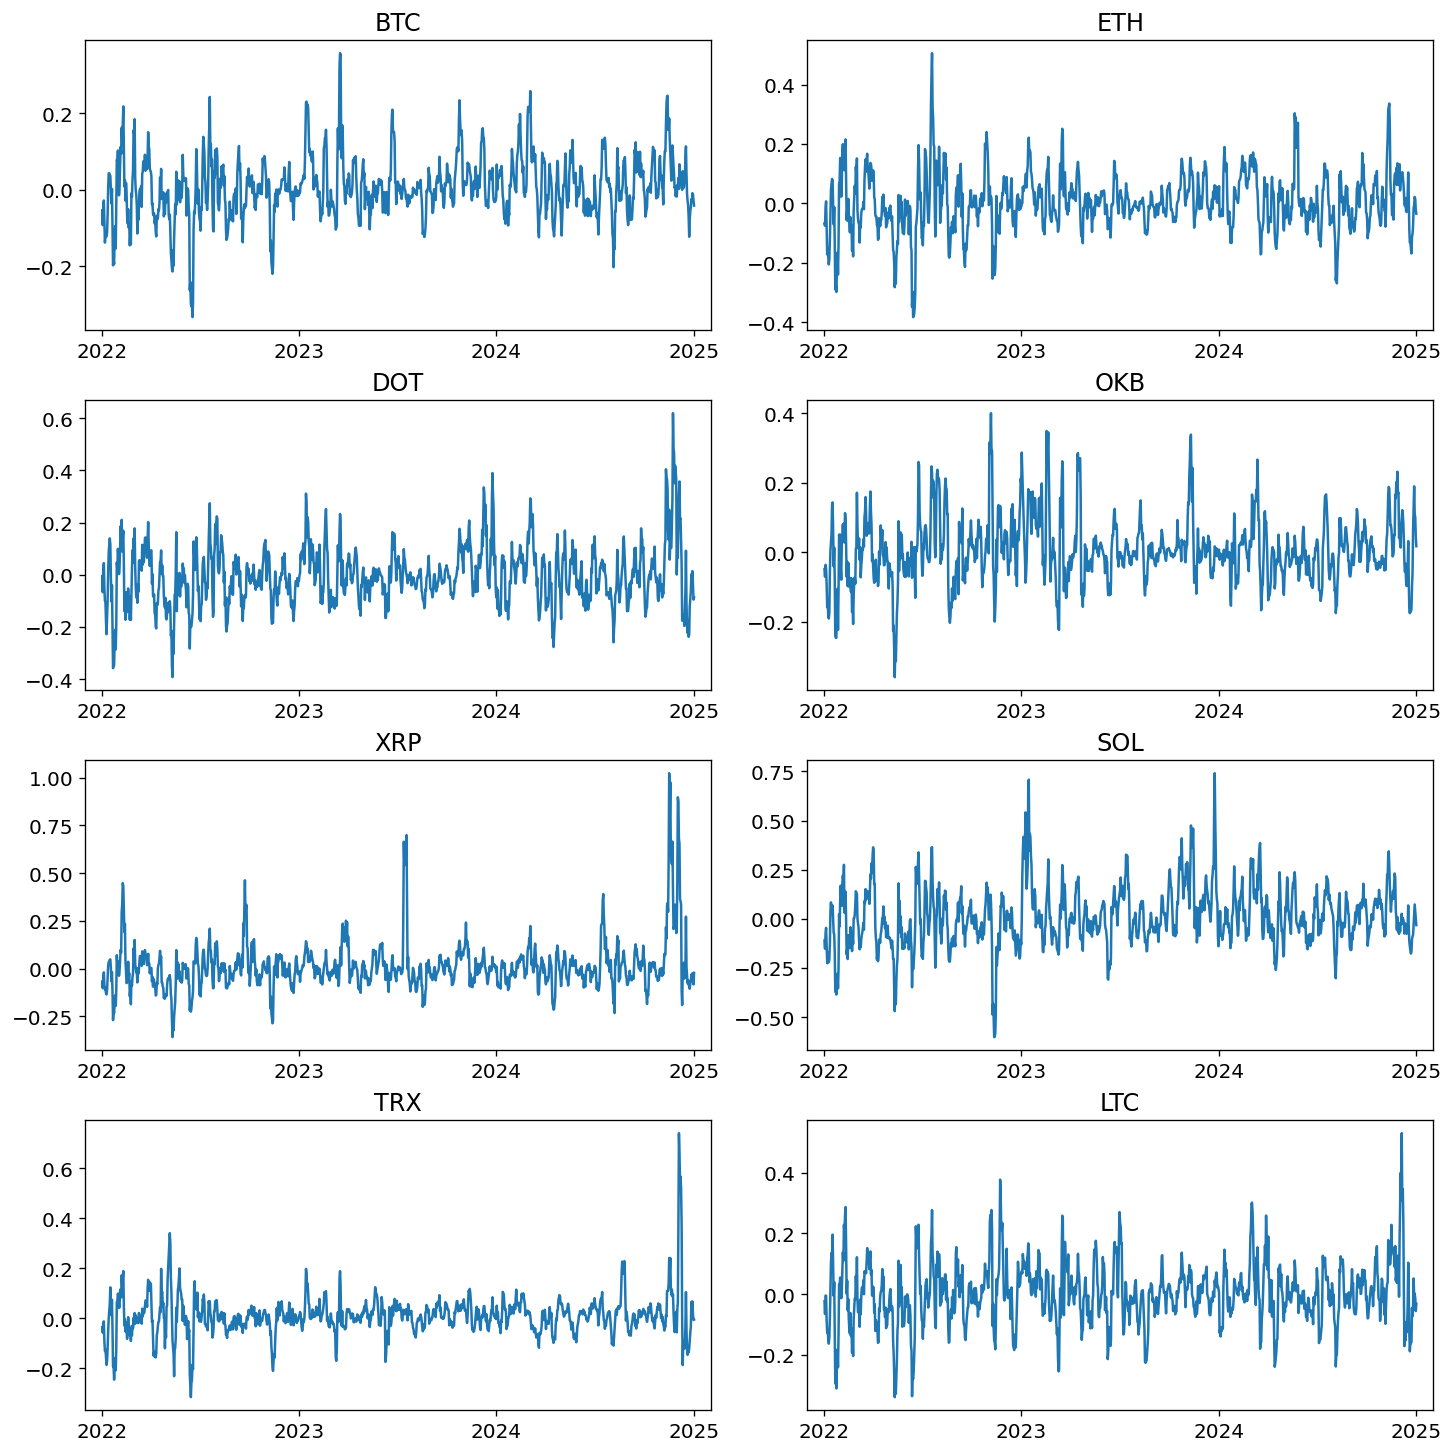

In [19]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 12), dpi=120, layout='constrained')
for c, ax in zip(df_returns.columns, axs.flatten()):
    ax.plot(df_returns[c])
    ax.set_title(c)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.set_xlim(datetime.date(2021, 12, 1), datetime.datetime(2025, 2, 1))
fig.savefig('../images/returns.png')

In [178]:
# таблица с описательной
df = df_returns.describe().drop('count')
df.index = map(lambda x: x.replace('%', '\\%'), df.index)
df.to_latex(
    '../tables/returns_describe.tex', 
    caption='Доходности активов',
    float_format='%.4f',
    position='h',
    )

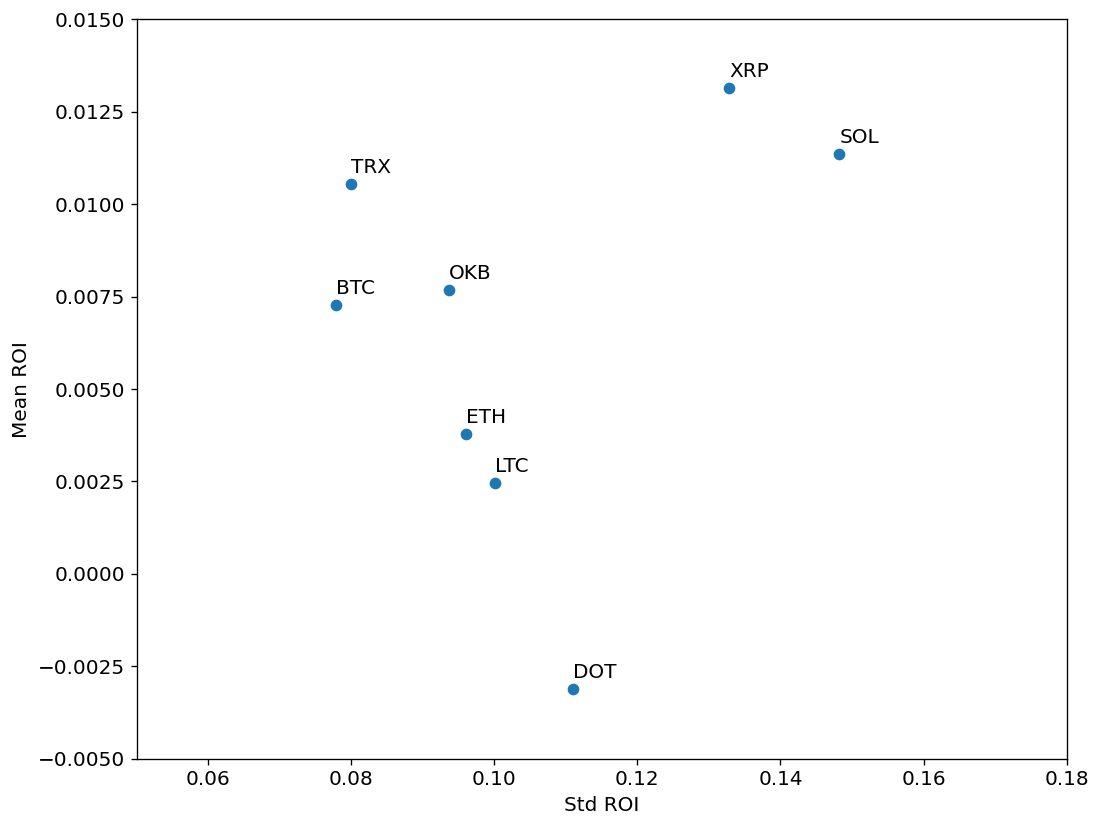

In [29]:
# риск-доходность
df = df_returns.describe().T
fig, ax = plt.subplots(figsize=(10, 8), dpi=120)

for i, row in df.iterrows():
    ax.annotate(i, (row['std'], row['mean'] + 0.0003))

ax.scatter(df['std'], df['mean'])
ax.set_xlabel('Std ROI')
ax.set_ylabel('Mean ROI')
ax.set_xlim(0.05, 0.18)
ax.set_ylim(-0.005, 0.015)

fig.savefig('../images/rois_mean_std.png')

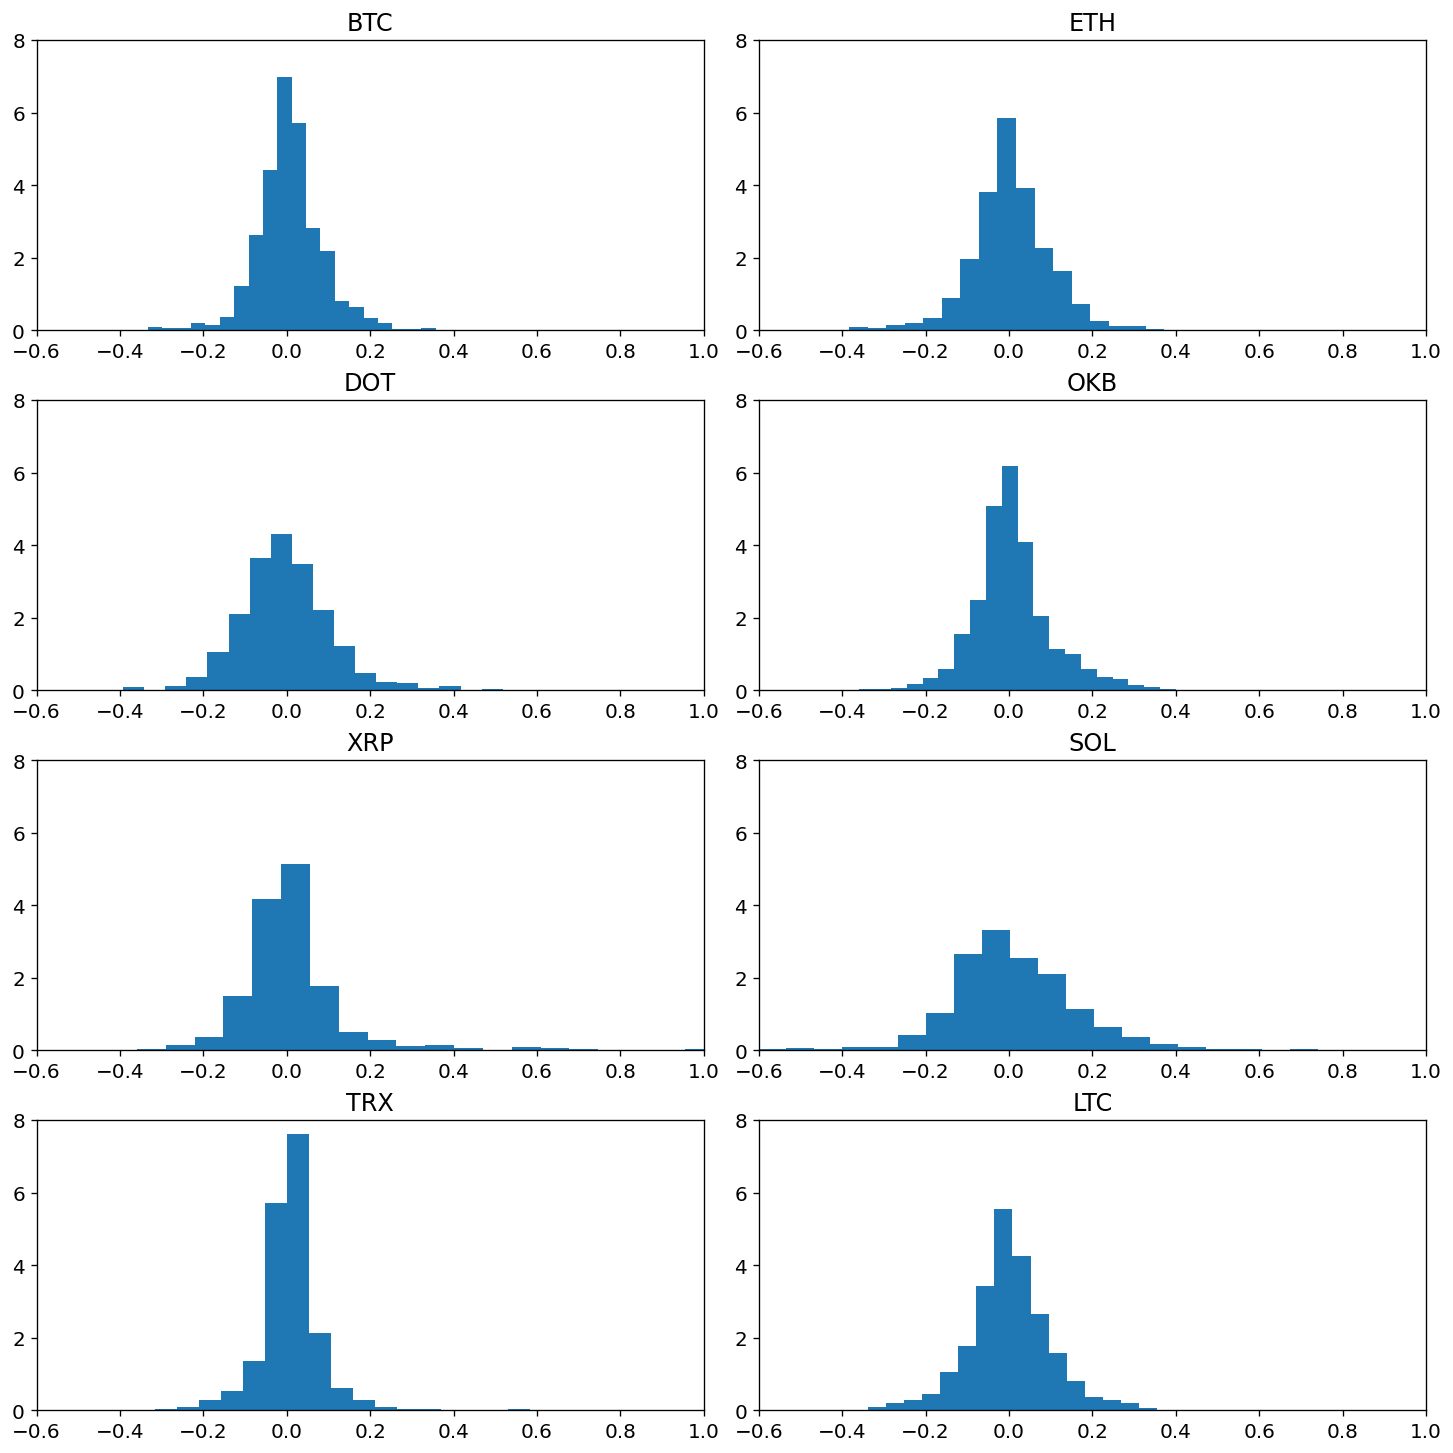

In [34]:
# распределение доходностей
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 12), dpi=120, layout='constrained')
for c, ax in zip(df_returns.columns, axs.flatten()):
    ax.hist(df_returns[c], bins=20, density=True)
    # ax.vlines(df_returns[c].mean(), *ax.get_ylim(), color='red')
    ax.set_title(c)
    ax.set_xlim(-0.6, 1)
    # ax.yaxis.set_visible(False)
    ax.set_ylim(0, 8)
fig.savefig('../images/rois_hist.png')

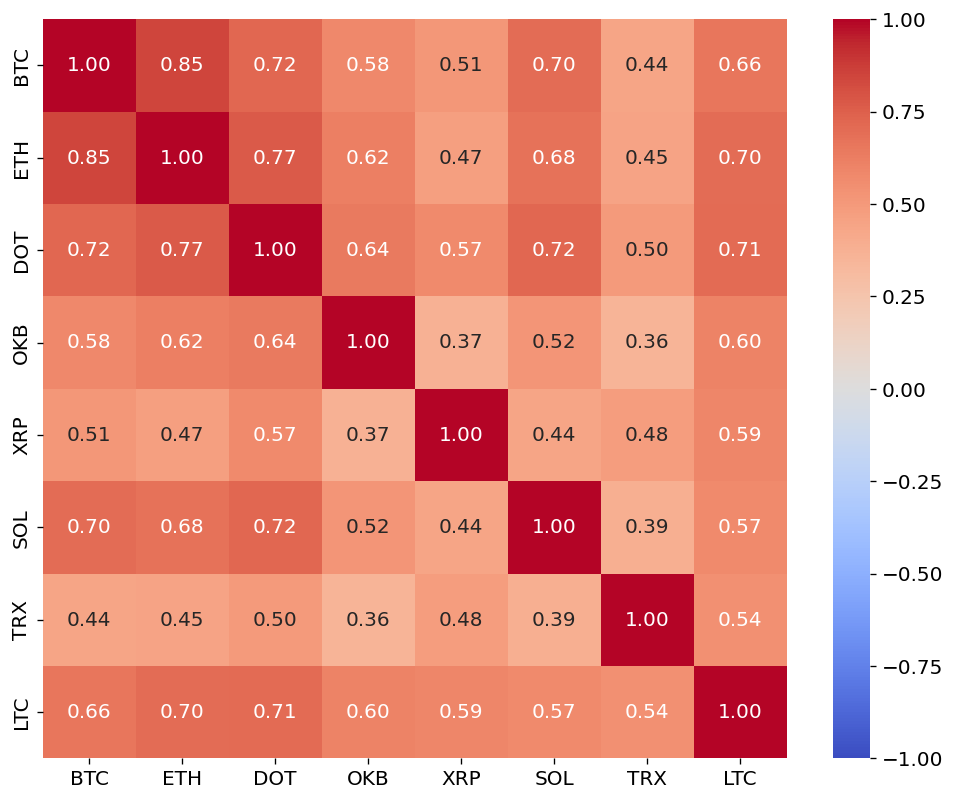

In [202]:
# корреляции
fig, ax = plt.subplots(figsize=(10, 8), dpi=120)
sns.heatmap(df_returns.corr(), vmin=-1, vmax=1, fmt='.2f', annot=True, ax=ax, cmap='coolwarm')
fig.savefig('../images/corr.png')

## Прогнозирование доходностей

In [211]:
df_returns

,BTC,ETH,DOT,OKB,XRP,SOL,TRX,LTC
dt,,,,,,,,
2022-01-01 19:00:00,-0.054014,-0.067913,-0.005263,-0.048031,-0.067994,-0.110254,-0.035776,-0.023856
2022-01-02 19:00:00,-0.092438,-0.075290,-0.067066,-0.070249,-0.103108,-0.151931,-0.058294,-0.065561
2022-01-03 19:00:00,-0.041478,-0.012844,0.008603,-0.035905,-0.054473,-0.072116,-0.022158,-0.004834
2022-01-04 19:00:00,-0.028151,0.006730,0.044412,-0.048068,-0.019920,-0.045850,-0.012687,-0.005669
2022-01-05 19:00:00,-0.088865,-0.083878,-0.050395,-0.093272,-0.089935,-0.138798,-0.092972,-0.086360
...,...,...,...,...,...,...,...,...
2024-12-27 19:00:00,-0.031560,-0.006595,-0.024435,0.189876,-0.037772,0.018749,0.043164,-0.009336
2024-12-28 19:00:00,-0.009079,0.021703,0.013931,0.110027,-0.024780,0.073090,0.067253,0.001392
2024-12-29 19:00:00,-0.012196,0.014207,-0.036427,0.101556,-0.055569,0.035434,0.014137,-0.013042


In [212]:
x = df_returns['BTC']
x

dt
2022-01-01 19:00:00   -0.054014
2022-01-02 19:00:00   -0.092438
2022-01-03 19:00:00   -0.041478
2022-01-04 19:00:00   -0.028151
2022-01-05 19:00:00   -0.088865
                         ...   
2024-12-27 19:00:00   -0.031560
2024-12-28 19:00:00   -0.009079
2024-12-29 19:00:00   -0.012196
2024-12-30 19:00:00   -0.029430
2024-12-31 19:00:00   -0.041456
Name: BTC, Length: 1095, dtype: float64

## Стратегии

In [203]:
# single assets
idx_most_risky = np.argmax(df_returns.describe().T['std'])
idx_less_risky = np.argmin(df_returns.describe().T['std'])
idx_best_return = np.argmax(df_returns.describe().T['mean'])
idx_worst_return = np.argmin(df_returns.describe().T['mean'])
idx_most_risky, idx_less_risky, idx_best_return, idx_worst_return


(5, 0, 4, 2)

In [50]:
# can short
def fixed_risk_max_return_optimizer(mu_hat, cov_hat, expected_risk):
    def objective(w):
        w = w.reshape((-1, 1))
        return -(w.T @ mu_hat).item()
    def unit_portfolio(w):
        return np.abs(w).sum() - 1
    def maximal_risk(w):
        w = w.reshape((-1, 1))
        return (expected_risk**2 - w.T @ cov_hat @ w).item()
    eq_cons = {
        'type': 'eq',
        'fun': unit_portfolio,
    }
    uneq_cons = {
        'type': 'ineq',
        'fun': maximal_risk,
    }
    bounds = [(-1, 1) for i in range(n_assets)]
    x0 = np.ones(n_assets) / n_assets
    sol = opt.minimize(
        fun=objective,
        x0=x0,
        method='SLSQP',
        bounds=bounds,
        constraints=[eq_cons, uneq_cons]
    )
    if sol.success:
        return sol.x

In [109]:
# long only
def fixed_risk_max_return_optimizer(mu_hat, cov_hat, expected_risk):
    def objective(w):
        w = w.reshape((-1, 1))
        return -(w.T @ mu_hat).item()
        
    def unit_portfolio(w):
        return np.abs(w).sum() - 1
        
    def maximal_risk(w):
        w = w.reshape((-1, 1))
        return (expected_risk**2 - w.T @ cov_hat @ w).item()
        
    eq_cons = {
        'type': 'eq',
        'fun': unit_portfolio,
    }
    bounds = [(-1, 1) for i in range(n_assets)]
    x0 = np.ones(n_assets) / n_assets
    sol = opt.minimize(
        fun=objective,
        x0=x0,
        method='SLSQP',
        bounds=bounds,
        constraints=[eq_cons]
    )
    if sol.success:
        return sol.x

In [204]:
def mean_std_optimizer(mu_hat, cov_hat, tau):
    def objective(w):
        w = w.reshape((-1, 1))
        return (w.T @ cov_hat @ w - tau * w.T @ mu_hat).item()
        
    def unit_portfolio(w):
        return np.abs(w).sum() - 1
        
    eq_cons = {
        'type': 'eq',
        'fun': unit_portfolio,
    }
    bounds = [(-1, 1) for i in range(n_assets)]
    x0 = np.ones(n_assets) / n_assets
    sol = opt.minimize(
        fun=objective,
        x0=x0,
        method='SLSQP',
        bounds=bounds,
        constraints=[eq_cons]
    )
    if sol.success:
        return sol.x

In [205]:
class SingleAssetStrategy:
    def __init__(self, idx):
        self.idx = idx
    def fit(self, df_hist):
        self.name = df_hist.columns[self.idx]
        if hasattr(self, 'w'):
            return self
        w = np.zeros(n_assets)        
        w[self.idx] = 1
        self.w = w
        return self
    def predict(self):
        return self.w

In [206]:
class UniformStrategy:
    def __init__(self, top_n=None):
        self.top_n = top_n
        self.name = 'uniform' + ('' if top_n is None else f'_{top_n}')
    def fit(self, df_hist):
        if hasattr(self, 'w'):
            return self
        if self.top_n is None:
            self.w = np.full(n_assets, 1 / n_assets)
        else:
            rets = df_returns.mean(axis=0).values
            mask = np.where(np.argsort(rets) < self.top_n, 1, 0)
            self.w =  mask / mask.sum()
        return self
    def predict(self):
        return self.w

In [207]:
class RandomPortfolio:
    def __init__(self, seed):
        np.random.seed(seed)
        self.name = f'random_{seed}'
    def fit(self, df_hist):
        w = np.random.randn(n_assets)
        w = w / np.abs(w).sum()
        self.w = w
        return self
    def predict(self):
        return self.w

In [208]:
class Naive_markowitz:
    def __init__(self, expected_risk=None, tau=None):
        self.expected_risk = expected_risk
        self.tau = tau
        self.name = f'naive_markowitz_{self.expected_risk}_{self.tau}'
        # self.name = f'naive_markowitz_{self.expected_risk:.4f}'

    def fit(self, df_history):
        self.mu_hat = df_history.mean(axis=0).values
        self.cov_hat = df_history.cov().values
        x = self._optimize_portfolio()
        self.w = x
        if x is None:
            print(self.name, 'not converged, setting zero portfolio')
            # self.w = np.zeros(n_assets)
            self.w = None
        return self
        
    def get_expected_mean_std(self):
        if self.w is None:
            return None, None
        roi_mean = (self.w.T @ self.mu_hat).item()
        roi_std = (self.w.T @ self.cov_hat @ self.w).item() ** 0.5
        return roi_mean, roi_std
        
    def predict(self):
        return self.w
    
    def _optimize_portfolio(self):
        if self.expected_risk is not None:
            return fixed_risk_max_return_optimizer(self.mu_hat, self.cov_hat, self.expected_rsk)
        if self.tau is not None:
            return mean_std_optimizer(self.mu_hat, self.cov_hat, self.tau)

In [209]:
class ARIMA_markowitz:
    def __init__(self, expected_risk=None, arima_order=None, tau=None):
        self.expected_risk = expected_risk
        self.arima_order = arima_order
        self.tau = tau
        self.name = f'arima_markowitz_{self.expected_risk}_{self.arima_order}_{self.tau}'
        # self.name = f'arima_markowitz_{self.expected_risk:.4f}_{self.arima_order}'

    def fit(self, df_history):
        self.mu_hat = self.estimate_mu(df_history)
        self.cov_hat = self.estimate_cov(df_history)
        x = self._optimize_portfolio()
        self.w = x
        if x is None:
            print(self.name, 'not converged, setting zero portfolio')
            self.w = None
        return self

    def estimate_mu(self, df_history):
        mu_hat = []
        for c in df_history.columns:
            x = df_history[c].reset_index(drop=True)
            model = ARIMA(x, order=self.arima_order).fit()
            mu_i = model.predict(
                start=len(df_returns.index) + days_shift,
                end=len(df_returns.index) + days_shift
            ).item()
            mu_hat.append(mu_i)
        return np.array(mu_hat)

    def get_expected_mean_std(self):
        if self.w is None:
            return None, None
        roi_mean = (self.w.T @ self.mu_hat).item()
        roi_std = (self.w.T @ self.cov_hat @ self.w).item() ** 0.5
        return roi_mean, roi_std

    def estimate_cov(self, df_history):
        return df_history.cov().values
        
    def predict(self):
        return self.w
    
    def _optimize_portfolio(self):
        if self.expected_risk is not None:
            return fixed_risk_max_return_optimizer(self.mu_hat, self.cov_hat, self.expected_risk)
        if self.tau is not None:
            return mean_std_optimizer(self.mu_hat, self.cov_hat, self.tau)

In [163]:
frontier_models = [
    [Naive_markowitz(tau=t) for t in np.linspace(0, 7, 10)],
    [ARIMA_markowitz(arima_order=(1, 0, 1), tau=t) for t in np.linspace(0, 7, 10)],
    [ARIMA_markowitz(arima_order=(2, 0, 2), tau=t) for t in np.linspace(0, 7, 10)],
]
plots = []
for model_set in frontier_models:
    xx = []
    yy = []
    for model in model_set:
        if model.fit(df_returns).predict() is None:
            continue
        roi_mean, roi_std = model.get_expected_mean_std()
        xx.append(roi_std)
        yy.append(roi_mean)
    plots.append((xx, yy))

C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary

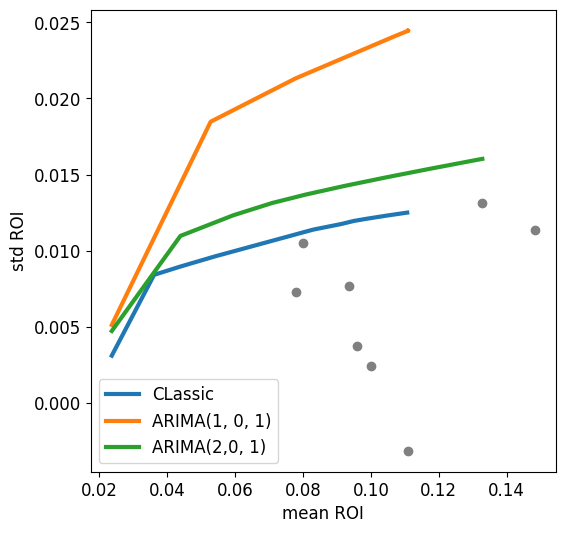

In [210]:
fig, ax = plt.subplots(figsize=(6, 6))

labels = ['CLassic', 'ARIMA(1, 0, 1)', 'ARIMA(2,0, 1)']
for (xx, yy), label in zip(plots, labels):
    ax.plot(xx, yy, label=label, linewidth=3)
    
df = df_returns.describe().T
ax.scatter(df['std'], df['mean'], c='grey')

ax.set_xlabel('mean ROI')
ax.set_ylabel('std ROI')
ax.legend()
fig.savefig('../images/frontier.png')

In [38]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning
warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', ConvergenceWarning)
# warnings.simplefilter('ignore', UserWarning)

## Бектест

In [40]:
min_history_leng = 50

strategies = [
    SingleAssetStrategy(idx_most_risky),
    SingleAssetStrategy(idx_less_risky),
    SingleAssetStrategy(idx_best_return),
    SingleAssetStrategy(idx_worst_return),

    UniformStrategy(),
    UniformStrategy(3),
    UniformStrategy(5),

    RandomPortfolio(1),
    RandomPortfolio(2),
    RandomPortfolio(3),

    Naive_markowitz(0.01),
    Naive_markowitz(0.03),
    Naive_markowitz(0.05),
    Naive_markowitz(0.07),
    Naive_markowitz(0.10),
    
    ARIMA_markowitz(0.01, (1, 0, 1)),
    ARIMA_markowitz(0.03, (1, 0, 1)),
    ARIMA_markowitz(0.05, (1, 0, 1)),
    ARIMA_markowitz(0.07, (1, 0, 1)),
    ARIMA_markowitz(0.10, (1, 0, 1)),

    ARIMA_markowitz(0.01, (2, 1, 2)),
    ARIMA_markowitz(0.03, (2, 1, 2)),
    ARIMA_markowitz(0.05, (2, 1, 2)),
    ARIMA_markowitz(0.07, (2, 1, 2)),
    ARIMA_markowitz(0.10, (2, 1, 2)),
]

rois = []
total_runs = n_observations - days_shift - min_history_leng
print(total_runs)
for t in tqdm.trange(total_runs):
    idx_history = min_history_leng + t
    idx_future = idx_history + days_shift - 1

    df_history = df_returns.iloc[:idx_history]
    df_future = df_returns.iloc[idx_future]

    rois_per_strategy = []
    for strategy in strategies:
        if t % 7 == 0:
            strategy.fit(df_history)
        w = strategy.predict(df_history)
        roi = np.nan
        if np.isclose(np.abs(w).sum(), 1):
            roi = np.dot(w, df_future.values)
        rois_per_strategy.append(roi)
    rois.append(rois_per_strategy)

rois = pd.DataFrame(rois, columns=[s.name for s in strategies])
rois.to_csv(f'checkpoints\\{datetime.datetime.today().strftime("%Y-%m-%d-%H-%M-%S")}.csv', index=False)

1038


  0%|          | 0/1038 [00:00<?, ?it/s]

C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible st

naive_markowitz_0.1000 not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

arima_markowitz_0.1000_(1, 0, 1) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

arima_markowitz_0.0300_(1, 0, 1) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

arima_markowitz_0.0100_(1, 0, 1) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

arima_markowitz_0.0100_(1, 0, 1) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible st

arima_markowitz_0.1000_(2, 1, 2) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-s

arima_markowitz_0.0100_(2, 1, 2) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-s

naive_markowitz_0.0100 not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


arima_markowitz_0.0100_(2, 1, 2) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

naive_markowitz_0.0100 not converged, setting zero portfolio
arima_markowitz_0.0100_(1, 0, 1) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


arima_markowitz_0.0100_(2, 1, 2) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

naive_markowitz_0.0100 not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-s

arima_markowitz_0.0100_(1, 0, 1) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

arima_markowitz_0.0100_(2, 1, 2) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

naive_markowitz_0.0100 not converged, setting zero portfolio
arima_markowitz_0.0100_(1, 0, 1) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

arima_markowitz_0.0100_(1, 0, 1) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

arima_markowitz_0.0100_(2, 1, 2) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

naive_markowitz_0.0100 not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

arima_markowitz_0.0100_(1, 0, 1) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

arima_markowitz_0.0100_(2, 1, 2) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

naive_markowitz_0.0100 not converged, setting zero portfolio
arima_markowitz_0.0100_(1, 0, 1) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

arima_markowitz_0.0100_(2, 1, 2) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

naive_markowitz_0.0100 not converged, setting zero portfolio
arima_markowitz_0.0100_(1, 0, 1) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting paramete

naive_markowitz_0.0100 not converged, setting zero portfolio
arima_markowitz_0.0100_(1, 0, 1) not converged, setting zero portfolio
arima_markowitz_0.0300_(1, 0, 1) not converged, setting zero portfolio
arima_markowitz_0.0500_(1, 0, 1) not converged, setting zero portfolio
arima_markowitz_0.0700_(1, 0, 1) not converged, setting zero portfolio
arima_markowitz_0.1000_(1, 0, 1) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting paramete

arima_markowitz_0.0100_(2, 1, 2) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting paramete

naive_markowitz_0.0100 not converged, setting zero portfolio
arima_markowitz_0.0100_(1, 0, 1) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


arima_markowitz_0.0100_(2, 1, 2) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

naive_markowitz_0.0100 not converged, setting zero portfolio
arima_markowitz_0.0100_(1, 0, 1) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


arima_markowitz_0.0100_(2, 1, 2) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as 

naive_markowitz_0.0100 not converged, setting zero portfolio
arima_markowitz_0.0100_(1, 0, 1) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting paramete

arima_markowitz_0.0100_(2, 1, 2) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting paramete

naive_markowitz_0.0100 not converged, setting zero portfolio
arima_markowitz_0.0100_(1, 0, 1) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

arima_markowitz_0.0100_(2, 1, 2) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

naive_markowitz_0.0100 not converged, setting zero portfolio
arima_markowitz_0.0100_(1, 0, 1) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting paramete

arima_markowitz_0.0100_(2, 1, 2) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting paramete

naive_markowitz_0.0100 not converged, setting zero portfolio
arima_markowitz_0.0100_(1, 0, 1) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


arima_markowitz_0.0100_(2, 1, 2) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

naive_markowitz_0.0100 not converged, setting zero portfolio
arima_markowitz_0.0100_(1, 0, 1) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


arima_markowitz_0.0100_(2, 1, 2) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

naive_markowitz_0.0100 not converged, setting zero portfolio
arima_markowitz_0.0100_(1, 0, 1) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


arima_markowitz_0.0100_(2, 1, 2) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

naive_markowitz_0.0100 not converged, setting zero portfolio
arima_markowitz_0.0100_(1, 0, 1) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


arima_markowitz_0.0100_(2, 1, 2) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

naive_markowitz_0.0100 not converged, setting zero portfolio
arima_markowitz_0.0100_(1, 0, 1) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

arima_markowitz_0.0100_(2, 1, 2) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

naive_markowitz_0.0100 not converged, setting zero portfolio
naive_markowitz_0.1000 not converged, setting zero portfolio
arima_markowitz_0.0100_(1, 0, 1) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

arima_markowitz_0.0100_(2, 1, 2) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

naive_markowitz_0.0100 not converged, setting zero portfolio
arima_markowitz_0.0100_(1, 0, 1) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

arima_markowitz_0.0100_(2, 1, 2) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

naive_markowitz_0.0100 not converged, setting zero portfolio
arima_markowitz_0.0100_(1, 0, 1) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

arima_markowitz_0.0100_(2, 1, 2) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

arima_markowitz_0.0700_(2, 1, 2) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

naive_markowitz_0.0100 not converged, setting zero portfolio
arima_markowitz_0.0100_(1, 0, 1) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

arima_markowitz_0.0100_(2, 1, 2) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

naive_markowitz_0.0100 not converged, setting zero portfolio
arima_markowitz_0.0100_(1, 0, 1) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

arima_markowitz_0.0100_(2, 1, 2) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

naive_markowitz_0.0100 not converged, setting zero portfolio
arima_markowitz_0.0100_(1, 0, 1) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

arima_markowitz_0.0100_(2, 1, 2) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

arima_markowitz_0.0500_(2, 1, 2) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

naive_markowitz_0.0100 not converged, setting zero portfolio
arima_markowitz_0.0100_(1, 0, 1) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

arima_markowitz_0.0100_(2, 1, 2) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

naive_markowitz_0.0100 not converged, setting zero portfolio
arima_markowitz_0.0100_(1, 0, 1) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

arima_markowitz_0.0100_(2, 1, 2) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

naive_markowitz_0.0100 not converged, setting zero portfolio
arima_markowitz_0.0100_(1, 0, 1) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


arima_markowitz_0.0100_(2, 1, 2) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

naive_markowitz_0.0100 not converged, setting zero portfolio
arima_markowitz_0.0100_(1, 0, 1) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


arima_markowitz_0.0100_(2, 1, 2) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting paramete

naive_markowitz_0.0100 not converged, setting zero portfolio
naive_markowitz_0.0300 not converged, setting zero portfolio
arima_markowitz_0.0100_(1, 0, 1) not converged, setting zero portfolio
arima_markowitz_0.0300_(1, 0, 1) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


arima_markowitz_0.0100_(2, 1, 2) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

naive_markowitz_0.0100 not converged, setting zero portfolio
naive_markowitz_0.0300 not converged, setting zero portfolio
arima_markowitz_0.0100_(1, 0, 1) not converged, setting zero portfolio
arima_markowitz_0.0300_(1, 0, 1) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting paramete

arima_markowitz_0.0100_(2, 1, 2) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting paramete

arima_markowitz_0.0300_(2, 1, 2) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting paramete

arima_markowitz_0.0700_(2, 1, 2) not converged, setting zero portfolio


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting paramete

naive_markowitz_0.0100 not converged, setting zero portfolio
naive_markowitz_0.0300 not converged, setting zero portfolio


 29%|██▉       | 301/1038 [11:26<28:00,  2.28s/it]


ValueError: Lengths must match to compare

In [1]:
pd.DataFrame([s.w for s in strategies[10:]])

NameError: name 'pd' is not defined

In [103]:
rois.describe()

,sol,btc,sol,dot,uniform,uniform_3,uniform_5,random_1,random_2,random_3,naive_markowitz_0.0100,naive_markowitz_0.0300,naive_markowitz_0.0500,naive_markowitz_0.0700,naive_markowitz_0.1000,"arima_markowitz_0.0100_(1, 0, 1)","arima_markowitz_0.0300_(1, 0, 1)","arima_markowitz_0.0500_(1, 0, 1)","arima_markowitz_0.0700_(1, 0, 1)","arima_markowitz_0.1000_(1, 0, 1)"
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,0.0,90.000000,100.000000,100.000000,95.000000,0.0,85.000000,100.000000,90.000000,100.000000
mean,0.080207,-0.027209,0.080207,-0.028157,0.023096,-0.006860,0.018377,-0.031322,0.012808,-0.033634,NaN,-0.009081,-0.003709,0.004119,0.012257,NaN,-0.013182,-0.000760,-0.003185,0.001942
std,0.231821,0.107194,0.231821,0.192756,0.182579,0.194889,0.183178,0.120616,0.067725,0.103467,NaN,0.036365,0.055867,0.080600,0.104896,NaN,0.057866,0.069090,0.084266,0.126629
min,-0.525357,-0.328081,-0.525357,-0.610514,-0.516138,-0.521325,-0.518629,-0.515234,-0.121260,-0.364213,NaN,-0.123586,-0.152159,-0.237029,-0.360385,NaN,-0.125800,-0.185085,-0.249691,-0.363425
25%,-0.052859,-0.099090,-0.052859,-0.126801,-0.079502,-0.119985,-0.074538,-0.081549,-0.040487,-0.099645,NaN,-0.028808,-0.044974,-0.048978,-0.043312,NaN,-0.047574,-0.040862,-0.045407,-0.069937
50%,0.070977,-0.015419,0.070977,-0.007526,0.015347,-0.004189,0.009869,-0.012174,0.013700,0.000228,NaN,-0.010777,-0.004551,0.003570,0.021544,NaN,-0.014749,-0.005189,-0.010841,-0.018416
75%,0.235940,0.040288,0.235940,0.098855,0.172505,0.096636,0.124867,0.034550,0.059395,0.030380,NaN,0.015192,0.040441,0.057122,0.076831,NaN,0.019001,0.041331,0.038162,0.039420
max,0.662892,0.263731,0.662892,0.356776,0.353658,0.493639,0.390694,0.233518,0.186283,0.148690,NaN,0.092505,0.133284,0.232151,0.270303,NaN,0.233432,0.216354,0.234806,0.343064


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\matplotlib\axes\_axes.py:7065: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\matplotlib\axes\_axes.py:7066: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

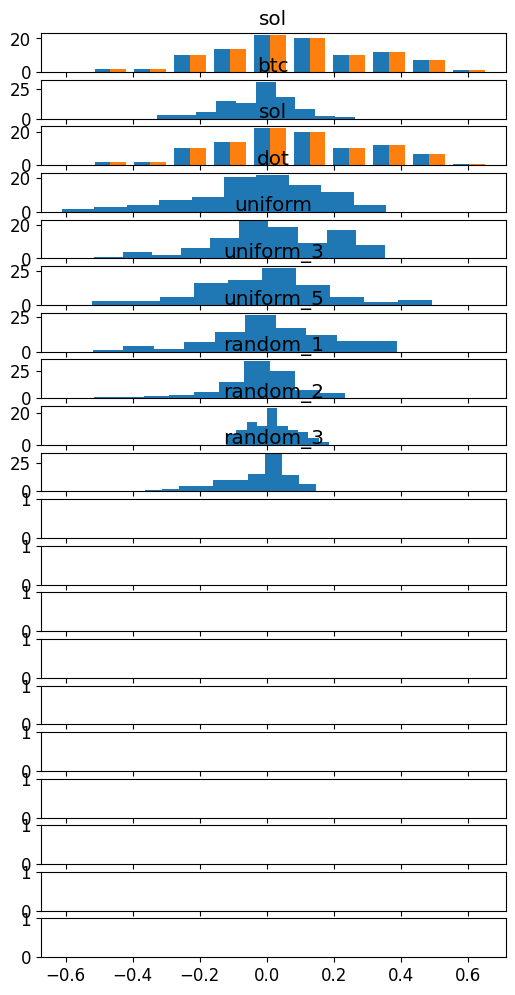

In [104]:
fig, axs = plt.subplots(nrows=len(strategies), sharex=True, figsize=(6, 12), dpi=100)
for c, ax in zip(rois.columns, axs):
    ax.hist(rois[c])
    ax.set_title(c)
    

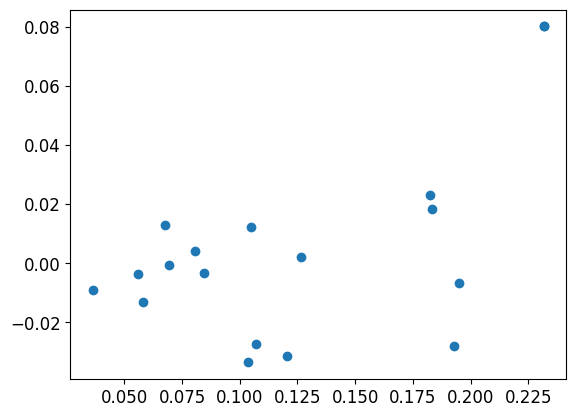

In [105]:
means = rois.describe().T['mean']
stds = rois.describe().T['std']
plt.scatter(stds, means)

In [57]:
df_stats.index

Index(['xrp-usdt', 'btc-usdt', 'sol-usdt', 'ltc-usdt', 'uniform', 'uniform_3',
       'uniform_5', 'random_1', 'random_2', 'random_3',
       'naive_markowitz_0.0100', 'naive_markowitz_0.0300',
       'naive_markowitz_0.0500', 'naive_markowitz_0.0700',
       'naive_markowitz_0.1000', 'arima_markowitz_0.0100_(1, 0, 1)',
       'arima_markowitz_0.0300_(1, 0, 1)', 'arima_markowitz_0.0500_(1, 0, 1)',
       'arima_markowitz_0.0700_(1, 0, 1)', 'arima_markowitz_0.1000_(1, 0, 1)'],
      dtype='object')

In [106]:
df_stats = rois.describe().T
means = df_stats['mean']
stds = df_stats['std']
# plt.scatter(stds, means)
means[['btc-usdt', 'xrp-usdt']]

single_asset_names = ['xrp-usdt', 'btc-usdt', 'sol-usdt', 'ltc-usdt']
trivial_names = ['uniform', 'uniform_3',
       'uniform_5', 'random_1', 'random_2', 'random_3']
naive_names = ['naive_markowitz_0.0100', 'naive_markowitz_0.0300',
       'naive_markowitz_0.0500', 'naive_markowitz_0.0700',
       'naive_markowitz_0.1000']
arima_names = ['arima_markowitz_0.0100_(1, 0, 1)',
       'arima_markowitz_0.0300_(1, 0, 1)', 'arima_markowitz_0.0500_(1, 0, 1)',
       'arima_markowitz_0.0700_(1, 0, 1)', 'arima_markowitz_0.1000_(1, 0, 1)']

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
for c, ax in zip([single_asset_names, trivial_names, naive_names, arima_names], axs.flatten()):
       means_blue = means[c]
       stds_blue = stds[c]

       means_grey = means.drop(c)
       stds_grey = stds.drop(c)
       
       ax.scatter(stds_grey, means_grey, c='grey')
       ax.scatter(stds_blue, means_blue, c='blue')

KeyError: "None of [Index(['btc-usdt', 'xrp-usdt'], dtype='object')] are in the [index]"

Text(0.5, 1.0, 'ROI Value at Risk (95%)')

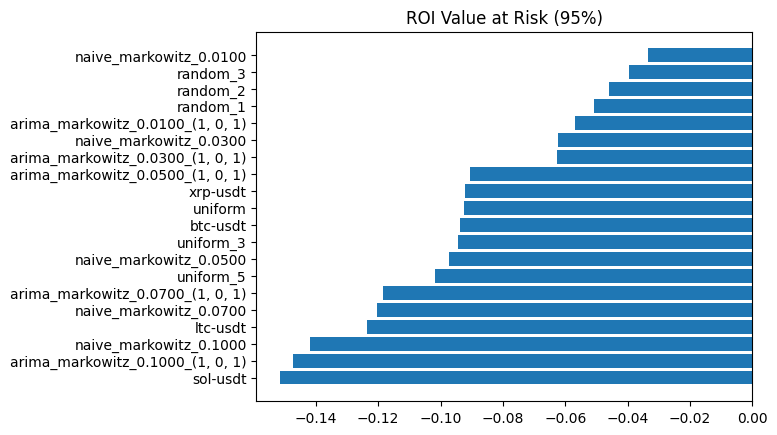

In [59]:
var_95 = rois.quantile(0.05).sort_values()
plt.barh(var_95.index, var_95.values)
plt.title('ROI Value at Risk (95%)')